In [31]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import pyramid as pm
from sklearn.externals import joblib
from collections import defaultdict
print(print(pm.__version__))

0.8.1
None


In [32]:
dn = pd.read_csv('../datasets/nights_2010-2017.csv',parse_dates=['date'], index_col='date',usecols=[*range(1, 15)])
dm = pd.read_csv('../datasets/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
dh = pd.read_csv('../datasets/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
dg = pd.read_csv('../datasets/regionalGDP_2010-2015.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
ll = pd.read_csv('../datasets/tc.csv')
dr = pd.concat([dn,dm,dh,dg], axis=1)
regions = ll.Region
df = dr.dropna()

In [41]:
joblib_file = "joblib_model.pkl"  
joblib.dump(model, joblib_file)
predict_year=2016
for region in regions:
    print("Cross Validation SARIMAX Region:",region,"Prediction year:",index)
    train_end = str(predict_year-1)+'-12-01'
    predict_start = str(predict_year)+'-01-01'
    predict_end = str(predict_year)+'-12-01'
    dfr = dr.loc[train_start:predict_end,dr.columns.str.contains(""+region+"|daysoff")]
    df_train = dfr.loc[train_start:train_end,dfr.columns.str.startswith('nights')]
    df_test = dfr.loc[predict_start:predict_end ,dfr.columns.str.startswith('nights')]
    df_train_exogenous = dfr.loc[train_start:train_end,~dfr.columns.str.startswith('nights')]
    df_test_exogenous =  dfr.loc[predict_start:predict_end,~dfr.columns.str.startswith('nights')]
    train = np.array(df_train)
    train_exogenous= np.array(df_train_exogenous)
    test = np.array(df_test)
    test_exogenous=np.array(df_test_exogenous)
    model = pm.auto_arima(y=train,exogenous=train_exogenous,start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                     start_P=1, seasonal=True, d=1, D=1, trace=False,
                     error_action='ignore',  # don't want to know if an order does not work
                     suppress_warnings=True,  # don't want convergence warnings
                     stepwise=True)
    model.fit(train,train_exogenous)
    joblib_file = region+".pkl"  
    joblib.dump(model, joblib_file)

Cross Validation SARIMAX Region: ARA Prediction year: 2016
Cross Validation SARIMAX Region: BFC Prediction year: 2016
Cross Validation SARIMAX Region: BRE Prediction year: 2016
Cross Validation SARIMAX Region: CVL Prediction year: 2016
Cross Validation SARIMAX Region: COR Prediction year: 2016
Cross Validation SARIMAX Region: IDF Prediction year: 2016
Cross Validation SARIMAX Region: NAQ Prediction year: 2016
Cross Validation SARIMAX Region: NOR Prediction year: 2016
Cross Validation SARIMAX Region: GES Prediction year: 2016
Cross Validation SARIMAX Region: HDF Prediction year: 2016
Cross Validation SARIMAX Region: OCC Prediction year: 2016
Cross Validation SARIMAX Region: PAC Prediction year: 2016
Cross Validation SARIMAX Region: PDL Prediction year: 2016


In [49]:
for region in regions:
    mc_fit = pm.auto_arima(y=np.array(df.gdp_PAC),start_p=0, start_q=0, max_p=3, max_q=3, m=12,
                    start_P=1, seasonal=False, d=1, D=1, trace=False,
                    error_action='ignore',  # don't want to know if an order does not work
                    suppress_warnings=True,  # don't want convergence warnings
                    stepwise=True)
    next_24 = mc_fit.predict(n_periods=24)
    dr.loc['2016-01-01':'2017-12-01','gdp_'+region] = next_24

/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

In [50]:
train_start = '2010-01-01'
all_mae = defaultdict(dict)
all_rmse = defaultdict(dict)
years_data = defaultdict(dict)
predicted_data = defaultdict(list)
for region in regions:
    for index in range(2012,2018):
        print("Cross Validation SARIMAX Region:",region,"Prediction year:",index)
        train_end = str(index-1)+'-12-01'
        predict_start = str(index)+'-01-01'
        predict_end = str(index)+'-12-01'
        dfr = dr.loc[train_start:predict_end,dr.columns.str.contains(""+region+"|daysoff")]
        df_train = dfr.loc[train_start:train_end,dfr.columns.str.startswith('nights')]
        df_test = dfr.loc[predict_start:predict_end ,dfr.columns.str.startswith('nights')]
        df_train_exogenous = dfr.loc[train_start:train_end,~dfr.columns.str.startswith('nights')]
        df_test_exogenous =  dfr.loc[predict_start:predict_end,~dfr.columns.str.startswith('nights')]
        train = np.array(df_train)
        train_exogenous= np.array(df_train_exogenous)
        test = np.array(df_test)
        test_exogenous=np.array(df_test_exogenous)
        joblib_file = region+".pkl"
        joblib_model = joblib.load(joblib_file)
        if index != 2016: 
            tc_fit = pm.arima.ARIMA (order=joblib_model.order,seasonal_order=joblib_model.seasonal_order,start_params=joblib_model.params())
            tc_fit.fit(train,train_exogenous)
            future_forecast = tc_fit.predict(n_periods=12,exogenous = test_exogenous)
        else:
            future_forecast = joblib_model.predict(n_periods=12,exogenous = test_exogenous)
        # --------Calculated error measures for each CV step----------
        mae = mean_absolute_error(test, future_forecast)
        mse = mean_squared_error(test,future_forecast)
        rmse = sqrt(mse)
        years_data[region][index]=df_train.index.strftime('%Y').unique().tolist()
        predicted_data[region].append(index)
        all_mae[region][index]=mae
        all_rmse[region][index]=rmse



Cross Validation SARIMAX Region: ARA Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: ARA Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: ARA Prediction year: 2014
Cross Validation SARIMAX Region: ARA Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: ARA Prediction year: 2016
Cross Validation SARIMAX Region: ARA Prediction year: 2017
Cross Validation SARIMAX Region: BFC Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: BFC Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: BFC Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: BFC Prediction year: 2015
Cross Validation SARIMAX Region: BFC Prediction year: 2016
Cross Validation SARIMAX Region: BFC Prediction year: 2017


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: BRE Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Cross Validation SARIMAX Region: BRE Prediction year: 2013
Cross Validation SARIMAX Region: BRE Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: BRE Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: BRE Prediction year: 2016
Cross Validation SARIMAX Region: BRE Prediction year: 2017
Cross Validation SARIMAX Region: CVL Prediction year: 2012
Cross Validation SARIMAX Region: CVL Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: CVL Prediction year: 2014
Cross Validation SARIMAX Region: CVL Prediction year: 2015
Cross Validation SARIMAX Region: CVL Prediction year: 2016
Cross Validation SARIMAX Region: CVL Prediction year: 2017
Cross Validation SARIMAX Region: COR Prediction year: 2012
Cross Validation SARIMAX Region: COR Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: COR Prediction year: 2014
Cross Validation SARIMAX Region: COR Prediction year: 2015
Cross Validation SARIMAX Region: COR Prediction year: 2016
Cross Validation SARIMAX Region: COR Prediction year: 2017
Cross Validation SARIMAX Region: IDF Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: IDF Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: IDF Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: IDF Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: IDF Prediction year: 2016
Cross Validation SARIMAX Region: IDF Prediction year: 2017
Cross Validation SARIMAX Region: NAQ Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: NAQ Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: NAQ Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: NAQ Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: NAQ Prediction year: 2016
Cross Validation SARIMAX Region: NAQ Prediction year: 2017


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: NOR Prediction year: 2012
Cross Validation SARIMAX Region: NOR Prediction year: 2013
Cross Validation SARIMAX Region: NOR Prediction year: 2014
Cross Validation SARIMAX Region: NOR Prediction year: 2015
Cross Validation SARIMAX Region: NOR Prediction year: 2016
Cross Validation SARIMAX Region: NOR Prediction year: 2017
Cross Validation SARIMAX Region: GES Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: GES Prediction year: 2013
Cross Validation SARIMAX Region: GES Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: GES Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: GES Prediction year: 2016
Cross Validation SARIMAX Region: GES Prediction year: 2017


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: HDF Prediction year: 2012
Cross Validation SARIMAX Region: HDF Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: HDF Prediction year: 2014
Cross Validation SARIMAX Region: HDF Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: HDF Prediction year: 2016
Cross Validation SARIMAX Region: HDF Prediction year: 2017
Cross Validation SARIMAX Region: OCC Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: OCC Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: OCC Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: OCC Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: OCC Prediction year: 2016
Cross Validation SARIMAX Region: OCC Prediction year: 2017


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PAC Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PAC Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PAC Prediction year: 2014
Cross Validation SARIMAX Region: PAC Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PAC Prediction year: 2016
Cross Validation SARIMAX Region: PAC Prediction year: 2017
Cross Validation SARIMAX Region: PDL Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PDL Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PDL Prediction year: 2014
Cross Validation SARIMAX Region: PDL Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PDL Prediction year: 2016
Cross Validation SARIMAX Region: PDL Prediction year: 2017


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Region ARA
Years of training data: ['2010', '2011']
Predicted year: 2017
RMSE: 4353.470187
MAE: 4353.036571
Years of training data: ['2010', '2011', '2012']
Predicted year: 2017
RMSE: 78.283097
MAE: 62.372236
Years of training data: ['2010', '2011', '2012', '2013']
Predicted year: 2017
RMSE: 107.858282
MAE: 79.075944
Years of training data: ['2010', '2011', '2012', '2013', '2014']
Predicted year: 2017
RMSE: 85.176903
MAE: 73.246572
Years of training data: ['2010', '2011', '2012', '2013', '2014', '2015']
Predicted year: 2017
RMSE: 706.656288
MAE: 703.802260
Years of training data: ['2010', '2011', '2012', '2013', '2014', '2015', '2016']
Predicted year: 2017
RMSE: 127.353591
MAE: 118.158623
Region BFC
Years of training data: ['2010', '2011']
Predicted year: 2017
RMSE: 23403.478382
MAE: 23403.465139
Years of training data: ['2010', '2011', '2012']
Predicted year: 2017
RMSE: 44.948471
MAE: 38.671377
Years of training data: ['2010', '2011', '2012', '2013']
Predicted year: 2017
RMSE: 23.0304

Region PDL
Years of training data: ['2010', '2011']
Predicted year: 2017
RMSE: 963.158455
MAE: 962.405232
Years of training data: ['2010', '2011', '2012']
Predicted year: 2017
RMSE: 26.797964
MAE: 18.723345
Years of training data: ['2010', '2011', '2012', '2013']
Predicted year: 2017
RMSE: 19.060745
MAE: 15.291274
Years of training data: ['2010', '2011', '2012', '2013', '2014']
Predicted year: 2017
RMSE: 36.249799
MAE: 29.715486
Years of training data: ['2010', '2011', '2012', '2013', '2014', '2015']
Predicted year: 2017
RMSE: 516.095626
MAE: 515.746481
Years of training data: ['2010', '2011', '2012', '2013', '2014', '2015', '2016']
Predicted year: 2017
RMSE: 21.965320
MAE: 20.123222


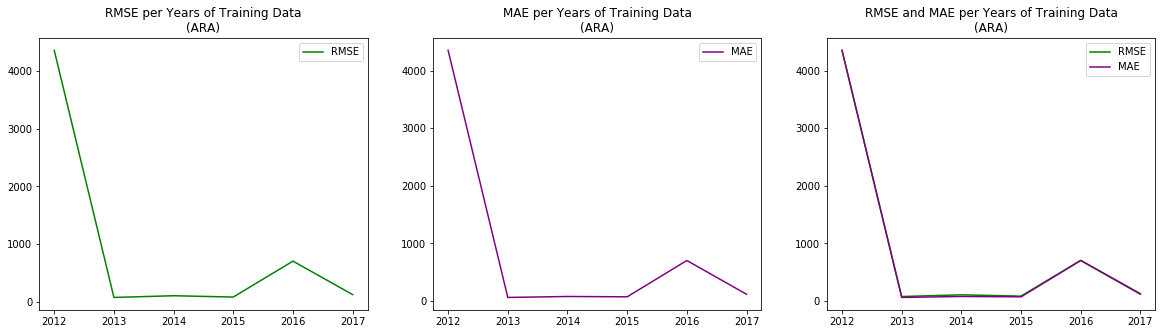

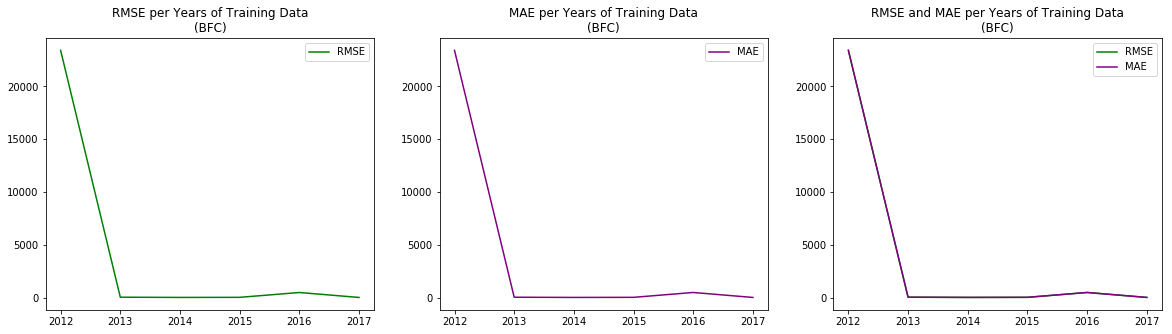

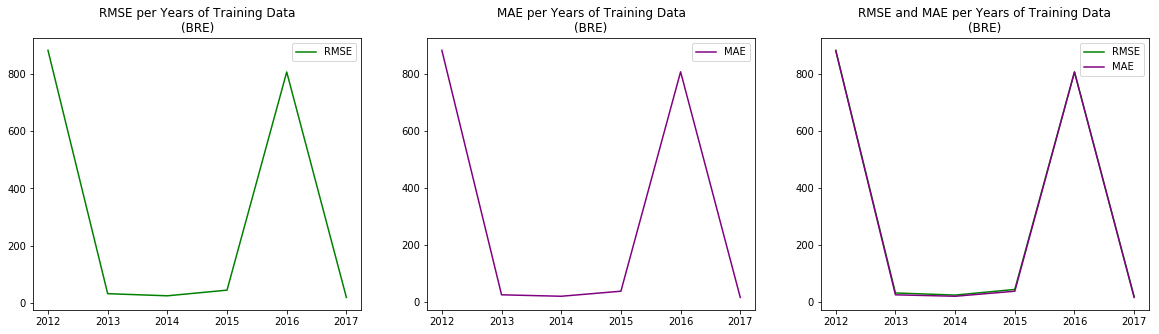

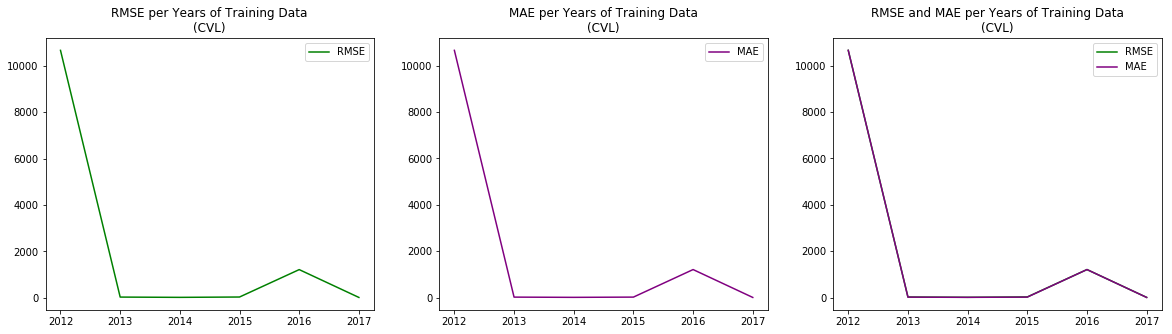

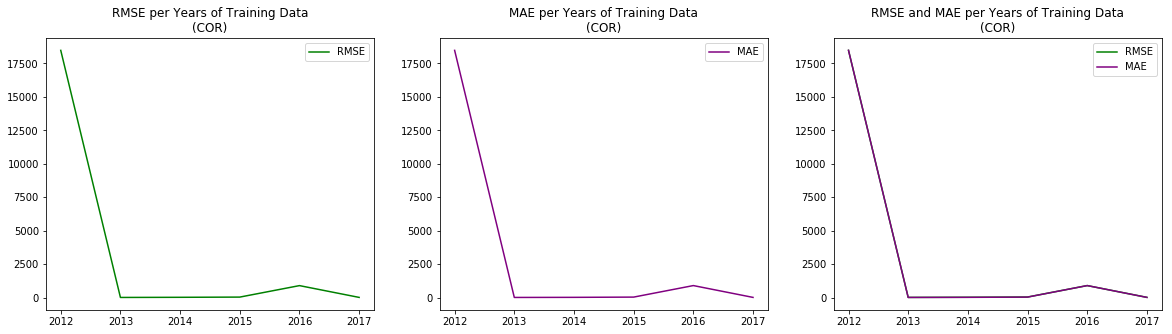

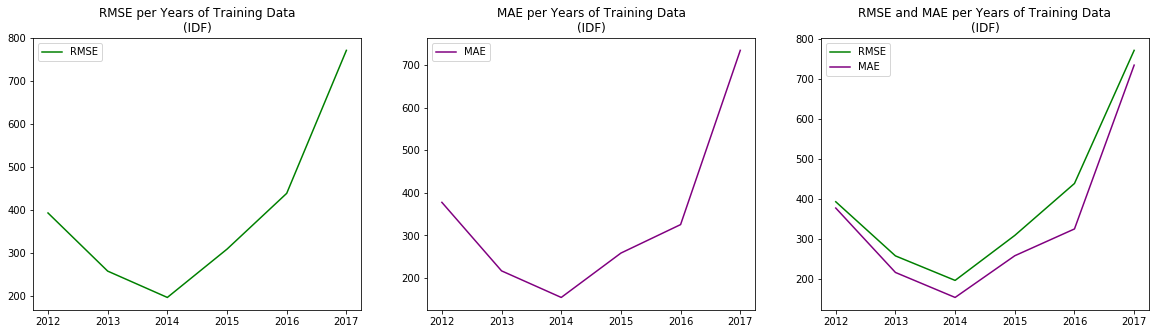

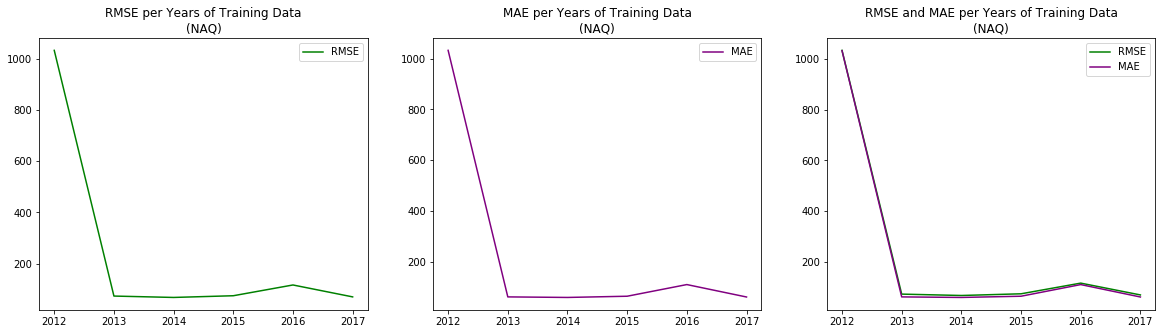

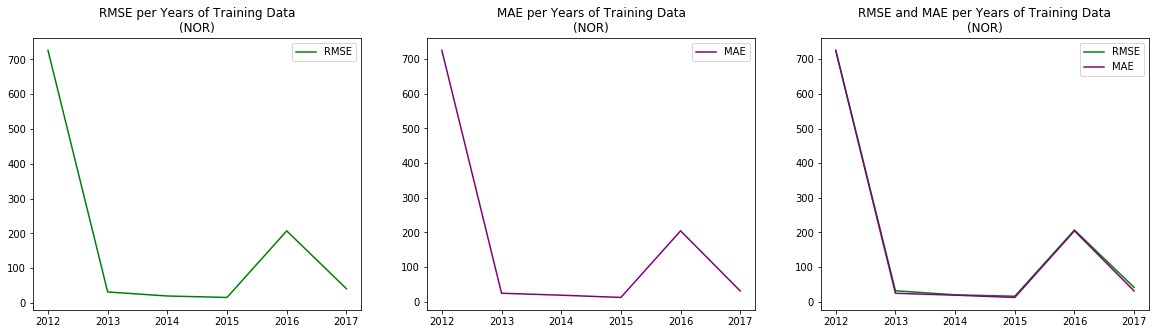

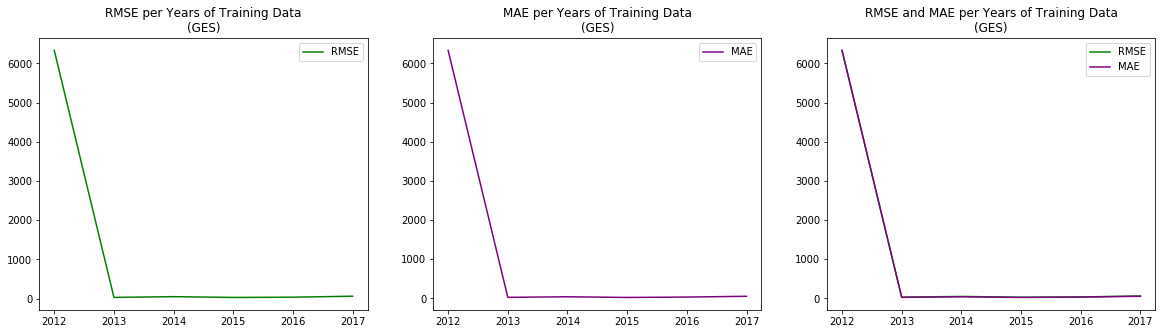

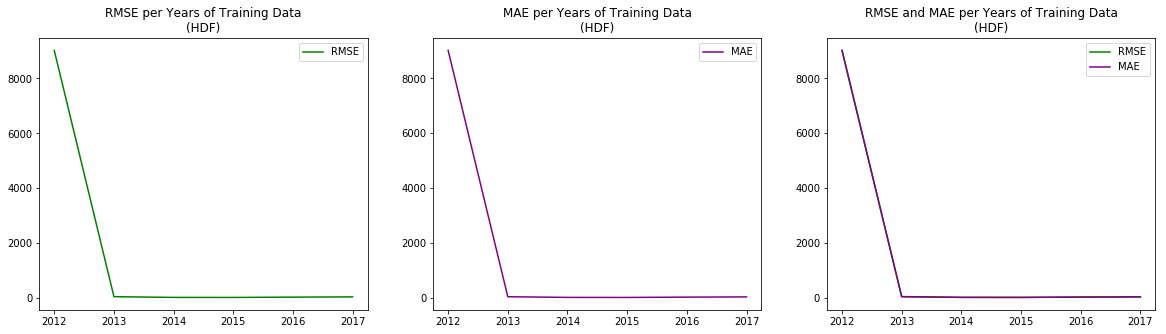

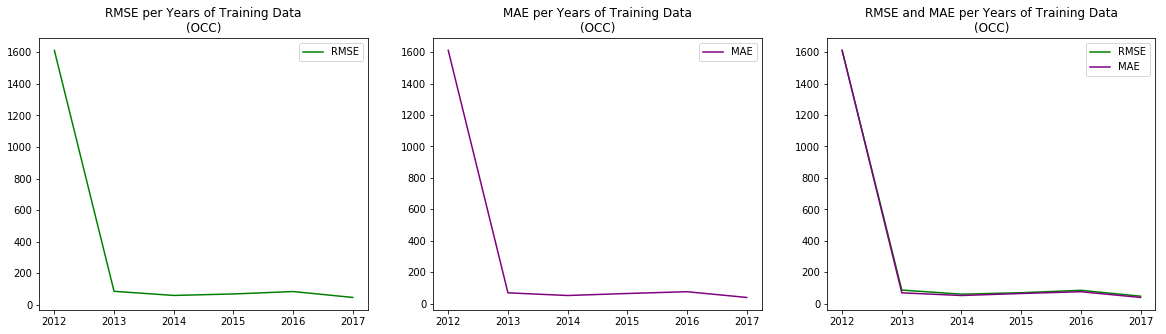

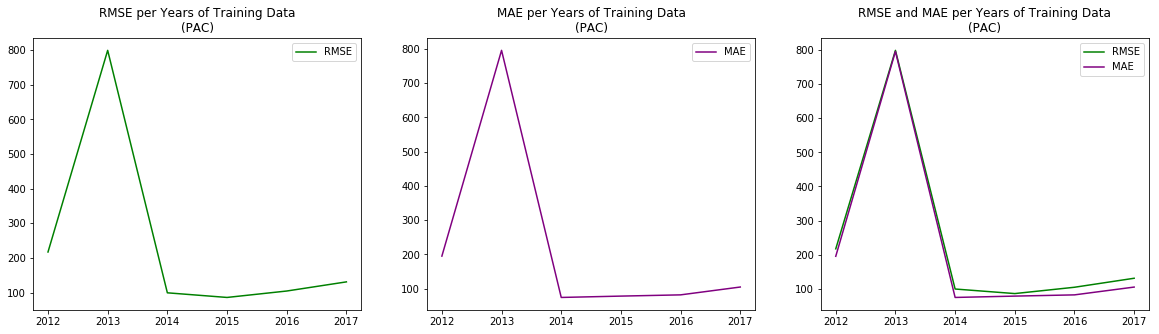

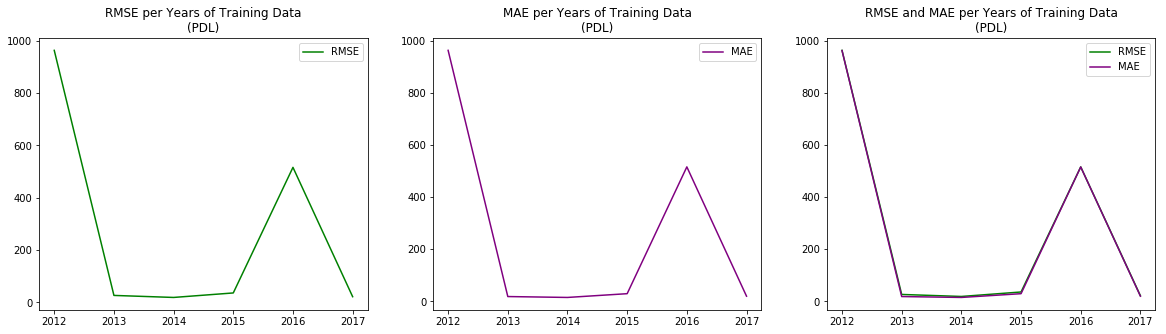

In [52]:
for region in regions:
        print("Region",region)
        for year in predicted_data[region]:
            print('Years of training data:', years_data[region][year])
            print('Predicted year:', index)
            print('RMSE: %f' % all_rmse[region][year])
            print('MAE: %f' % all_mae[region][year])

             # Error measures per CrossVal loop (number of years of training data used)
        years = predicted_data[region]    
        fig, axes = plt.subplots(1,3, figsize=(20,5))
        x = list(range(len(years)))
        axes[0].plot(x, np.array([all_rmse[region][index] for index in years]), label='RMSE', color='green')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(years_data[region])
        axes[0].set_title('RMSE per Years of Training Data' + '\n' + f'({region})')
        axes[0].legend()

        axes[1].plot(x, [all_mae[region][index] for index in years], label='MAE', color='purple')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(years_data[region])
        axes[1].set_title('MAE per Years of Training Data' + '\n' + f'({region})')
        axes[1].legend()

        axes[2].plot(x, [all_rmse[region][index] for index in years], label='RMSE', color='green')
        axes[2].plot(x, [all_mae[region][index] for index in years], label='MAE', color='purple')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(years_data[region])
        axes[2].set_title('RMSE and MAE per Years of Training Data' + '\n' + f'({region})')
        axes[2].legend();   
        plt.savefig(region+'.png')

In [49]:
years_data[region][index]

['2010', '2011', '2012', '2013', '2014', '2015', '2016']

In [ ]:
tc_fit = defaultdict(dict)
df = dr.dropna()
for region in regions:
    dfr = df.loc[:,df.columns.str.contains(""+region+"|daysoff")]
    y = np.array(dfr.loc[:,dfr.columns.str.startswith('nights')])
    exogenous= np.array(dfr.loc[:,~dfr.columns.str.startswith('nights')])
    tc_fit[region] = auto_arima(y=y,exogenous=exogenous,start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                     start_P=1, seasonal=True, d=1, D=1, trace=False,
                     error_action='ignore',  # don't want to know if an order does not work
                     suppress_warnings=True,  # don't want convergence warnings
                     stepwise=True)